In [14]:
import os
import cv2
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd


In [15]:
# Define paths
train_dir = "dataset/datasetsplitted/train"
test_dir = "dataset/datasetsplitted/test"

# Check if dataset directories exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("Dataset directories not found. Please verify the path.")

In [16]:
# SIFT feature extractor
sift = cv2.SIFT_create()

# Function to extract SIFT features
def extract_sift_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

# Collecting descriptors for images
image_features = {}

# Read images and extract SIFT features
for car_model in os.listdir(train_dir):
    model_path = os.path.join(train_dir, car_model)
    
    if os.path.isdir(model_path):
        for img_name in tqdm(os.listdir(model_path), desc=f"Processing {car_model}"):
            img_path = os.path.join(model_path, img_name)
            descriptors = extract_sift_features(img_path)
            if descriptors is not None:
                image_features[img_path] = descriptors

# Convert features to a consistent format (averaging descriptors per image)
X = np.array([np.mean(desc, axis=0) for desc in image_features.values() if desc is not None])

Processing volkswagen tiguan: 100%|██████████| 147/147 [00:02<00:00, 59.07it/s]


In [17]:
# Determine optimal clusters using Silhouette Score
cluster_range = range(2, 21) #I have 20 subfolders in the dataset so I am taking 20 clusters + 1
silhouette_scores = []

for k in cluster_range:
    gmm = GaussianMixture(n_components=k, random_state=42, init_params='k-means++', max_iter=500, tol=0.001, covariance_type='full', reg_covar=0.001)
    labels = gmm.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

# Find optimal number of clusters
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]

# Fit GMM with optimal number of clusters
gmm = GaussianMixture(n_components=optimal_clusters, random_state=42, init_params='k-means++', max_iter=500, tol=0.001, covariance_type='full', reg_covar=0.001)
labels = gmm.fit_predict(X)

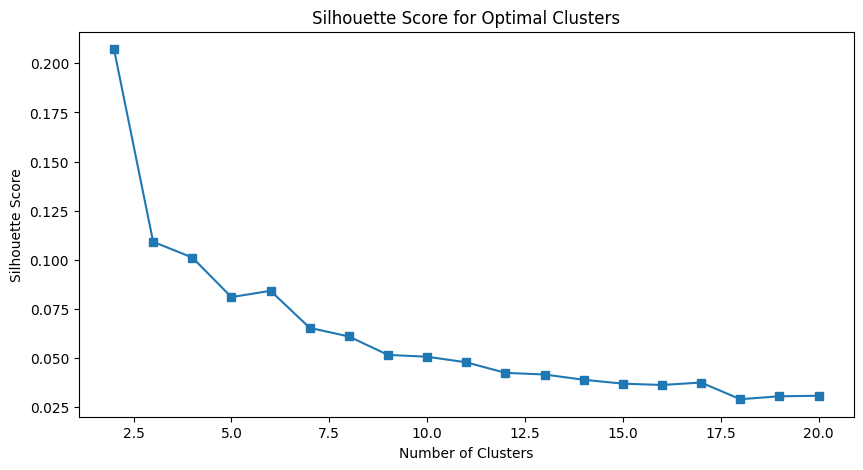

In [18]:

# Plot Silhouette Score to find optimal clusters
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker='s', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.show()


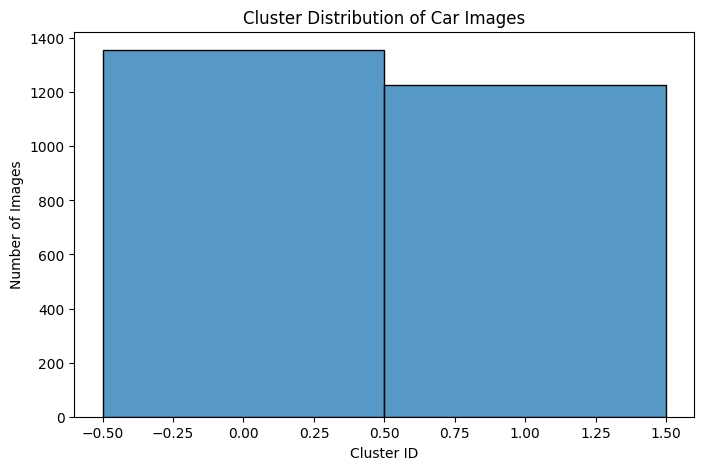

In [19]:
#Cluster Distribution Plot
plt.figure(figsize=(8, 5))
sns.histplot(labels, bins=optimal_clusters, kde=False, discrete=True)
plt.xlabel("Cluster ID")
plt.ylabel("Number of Images")
plt.title("Cluster Distribution of Car Images")
plt.show()

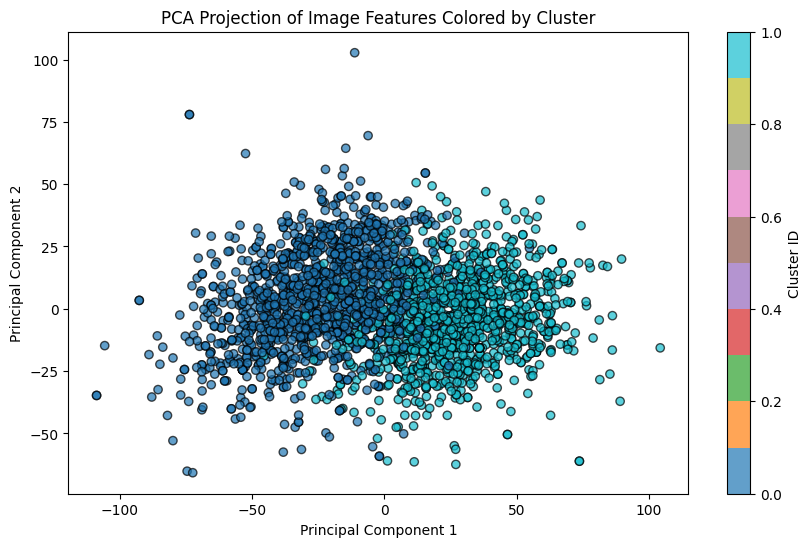

In [20]:
from sklearn.decomposition import PCA

#PCA Projection for 2D visualization
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10", alpha=0.7, edgecolors="k")
plt.colorbar(label="Cluster ID")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Image Features Colored by Cluster")
plt.show()

In [21]:
#Print silhouette score
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Silhouette Score: {silhouette_scores[optimal_clusters-2]}")

Optimal Number of Clusters: 2
Silhouette Score: 0.20721551775932312


Processing volkswagen tiguan (Test Set): 100%|██████████| 37/37 [00:00<00:00, 55.94it/s]


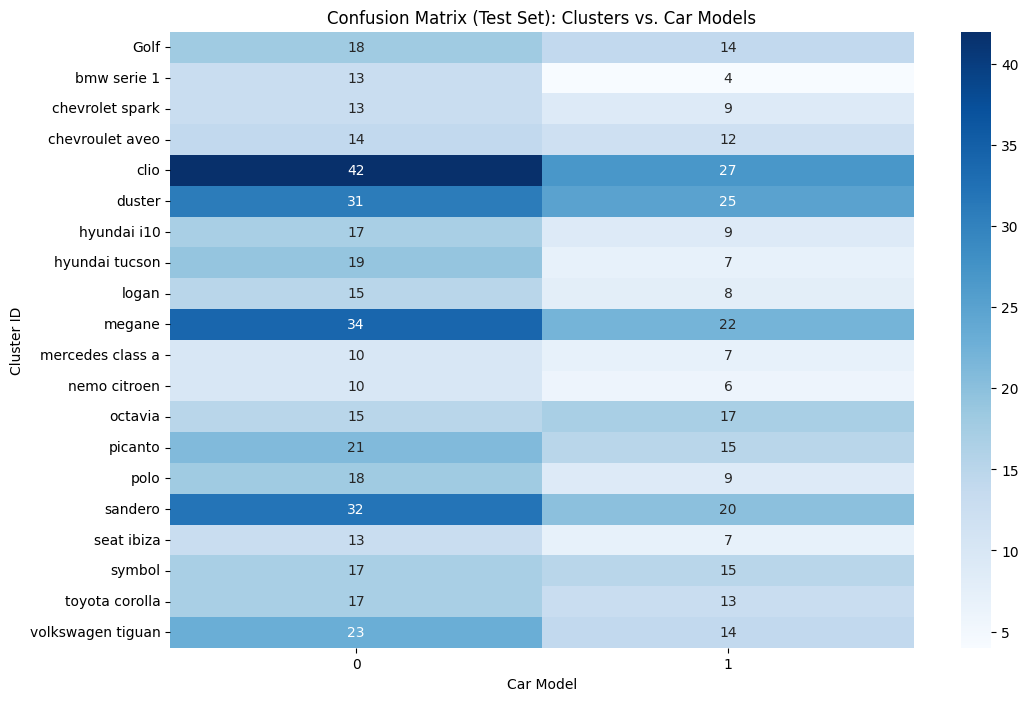

Cluster Purity (Test Set): 0.1058


In [22]:
# Extract SIFT features from test images
test_features = {}

for car_model in os.listdir(test_dir):
    model_path = os.path.join(test_dir, car_model)
    
    if os.path.isdir(model_path):
        for img_name in tqdm(os.listdir(model_path), desc=f"Processing {car_model} (Test Set)"):
            img_path = os.path.join(model_path, img_name)
            descriptors = extract_sift_features(img_path)
            if descriptors is not None:
                test_features[img_path] = descriptors

# Convert test features to a consistent format
X_test = np.array([np.mean(desc, axis=0) for desc in test_features.values() if desc is not None])

# Predict clusters for test images using the trained GMM model
test_labels = gmm.predict(X_test)

# Create a DataFrame mapping test images to cluster assignments
df_test = pd.DataFrame({"Image": list(test_features.keys()), "Cluster": test_labels})

# Extract car model names from the image paths
df_test["CarModel"] = df_test["Image"].apply(lambda x: os.path.basename(os.path.dirname(x)))

# Create confusion matrix for test set
conf_matrix_test = pd.crosstab(df_test["Cluster"], df_test["CarModel"])

# Compute Cluster Purity for test set
majority_counts_test = conf_matrix_test.max(axis=1)  # Maximum count in each cluster
total_samples_test = conf_matrix_test.sum(axis=1)  # Total samples per cluster
purity_scores_test = majority_counts_test / total_samples_test
overall_purity_test = np.sum(majority_counts_test) / np.sum(total_samples_test)

# Display confusion matrix as heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_test.T, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Car Model")
plt.ylabel("Cluster ID")
plt.title("Confusion Matrix (Test Set): Clusters vs. Car Models")
plt.show()

# Display Cluster Purity Score for test set
print(f"Cluster Purity (Test Set): {overall_purity_test:.4f}")
